_Developer Note:_ if you may make a PR in the future, be sure to copy this
notebook, and use the `gitignore` prefix `temp` to avoid future conflicts.

This is one notebook in a multi-part series on clusterless decoding in Spyglass

- To set up your Spyglass environment and database, see
  [the Setup notebook](./00_Setup.ipynb)
- For additional info on DataJoint syntax, including table definitions and
  inserts, see
  [the Insert Data notebook](./01_Insert_Data.ipynb)
- Prior to running, please familiarize yourself with the [spike sorting
  pipeline](./02_Spike_Sorting.ipynb) and generate input position data with
  either the [Trodes](./20_Position_Trodes.ipynb) or DLC notebooks
  ([1](./21_Position_DLC_1.ipynb), [2](./22_Position_DLC_2.ipynb),
  [3](./23_Position_DLC_3.ipynb)).

The goal of this notebook is to populate the `UnitWaveformFeatures` table, which depends `SpikeSortingOutput`. This table contains the features of the waveforms of each unit.

While clusterless decoding avoids actual spike sorting, we need to pass through these tables to maintain (relative) pipeline simplicity. Pass-through tables keep spike sorting and clusterless waveform extraction as similar as possible, by using shared steps. Here, "spike sorting" involves simple thresholding (sorter: clusterless_thresholder).


In [1]:
from pathlib import Path
import datajoint as dj

dj.config.load(
    Path("../dj_local_conf.json").absolute()
)  # load config for database connection info

First, if you haven't inserted the the `mediumnwb20230802.wnb` file into the database, you should do so now. This is the file that we will use for the decoding tutorials.

It is a truncated version of the full NWB file, so it will run faster, but bigger than the minirec file we used in the previous tutorials so that decoding makes sense.


In [2]:
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
import spyglass.data_import as sgi
import spyglass.position as sgp

# Insert the nwb file
nwb_file_name = "mediumnwb20230802.nwb"
nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)
sgi.insert_sessions(nwb_file_name)

# Position
sgp.v1.TrodesPosParams.insert_default()

interval_list_name = "pos 0 valid times"

trodes_s_key = {
    "nwb_file_name": nwb_copy_file_name,
    "interval_list_name": interval_list_name,
    "trodes_pos_params_name": "default",
}
sgp.v1.TrodesPosSelection.insert1(
    trodes_s_key,
    skip_duplicates=True,
)
sgp.v1.TrodesPosV1.populate(trodes_s_key)

[2024-01-17 22:14:51,194][INFO]: Connecting root@localhost:3306
[2024-01-17 22:14:51,274][INFO]: Connected root@localhost:3306
/Users/edeno/Documents/GitHub/spyglass/src/spyglass/data_import/insert_sessions.py:58: UserWarning: Cannot insert data from mediumnwb20230802.nwb: mediumnwb20230802_.nwb is already in Nwbfile table.
  warnings.warn(


These next steps are the same as in the [Spike Sorting notebook](./10_Spike_SortingV1.ipynb), but we'll repeat them here for clarity. These are pre-processing steps that are shared between spike sorting and clusterless decoding.

We first set the `SortGroup` to define which contacts are sorted together.

We then setup for spike sorting by bandpass filtering and whitening the data via the `SpikeSortingRecording` table.


In [3]:
import spyglass.spikesorting.v1 as sgs

sgs.SortGroup.set_group_by_shank(nwb_file_name=nwb_copy_file_name)

sort_group_ids = (sgs.SortGroup & {"nwb_file_name": nwb_copy_file_name}).fetch(
    "sort_group_id"
)

group_keys = []
for sort_group_id in sort_group_ids:
    key = {
        "nwb_file_name": nwb_copy_file_name,
        "sort_group_id": sort_group_id,
        "interval_list_name": interval_list_name,
        "preproc_param_name": "default",
        "team_name": "Alison Comrie",
    }
    group_keys.append(key)
    sgs.SpikeSortingRecordingSelection.insert_selection(key)

sgs.SpikeSortingRecording.populate(group_keys)

[22:14:55][WARNING] Spyglass: Similar row(s) already inserted.
[22:14:55][WARNING] Spyglass: Similar row(s) already inserted.
[22:14:55][WARNING] Spyglass: Similar row(s) already inserted.
[22:14:55][WARNING] Spyglass: Similar row(s) already inserted.
[22:14:55][WARNING] Spyglass: Similar row(s) already inserted.
[22:14:55][WARNING] Spyglass: Similar row(s) already inserted.
[22:14:55][WARNING] Spyglass: Similar row(s) already inserted.
[22:14:55][WARNING] Spyglass: Similar row(s) already inserted.
[22:14:55][WARNING] Spyglass: Similar row(s) already inserted.
[22:14:55][WARNING] Spyglass: Similar row(s) already inserted.
[22:14:55][WARNING] Spyglass: Similar row(s) already inserted.
[22:14:55][WARNING] Spyglass: Similar row(s) already inserted.
[22:14:55][WARNING] Spyglass: Similar row(s) already inserted.
[22:14:55][WARNING] Spyglass: Similar row(s) already inserted.
[22:14:55][WARNING] Spyglass: Similar row(s) already inserted.
[22:14:55][WARNING] Spyglass: Similar row(s) already in

Next we do artifact detection. Here we skip it by setting the `artifact_param_name` to `None`, but in practice you should detect artifacts as it will affect the decoding.


In [4]:
recording_ids = (
    sgs.SpikeSortingRecordingSelection & {"nwb_file_name": nwb_copy_file_name}
).fetch("recording_id")

group_keys = []
for recording_id in recording_ids:
    key = {
        "recording_id": recording_id,
        "artifact_param_name": "none",
    }
    group_keys.append(key)
    sgs.ArtifactDetectionSelection.insert_selection(key)

sgs.ArtifactDetection.populate(group_keys)

[22:14:56][WARNING] Spyglass: Similar row(s) already inserted.
[22:14:56][WARNING] Spyglass: Similar row(s) already inserted.
[22:14:56][WARNING] Spyglass: Similar row(s) already inserted.
[22:14:56][WARNING] Spyglass: Similar row(s) already inserted.
[22:14:56][WARNING] Spyglass: Similar row(s) already inserted.
[22:14:56][WARNING] Spyglass: Similar row(s) already inserted.
[22:14:56][WARNING] Spyglass: Similar row(s) already inserted.
[22:14:56][WARNING] Spyglass: Similar row(s) already inserted.
[22:14:56][WARNING] Spyglass: Similar row(s) already inserted.
[22:14:56][WARNING] Spyglass: Similar row(s) already inserted.
[22:14:56][WARNING] Spyglass: Similar row(s) already inserted.
[22:14:56][WARNING] Spyglass: Similar row(s) already inserted.
[22:14:56][WARNING] Spyglass: Similar row(s) already inserted.
[22:14:56][WARNING] Spyglass: Similar row(s) already inserted.
[22:14:56][WARNING] Spyglass: Similar row(s) already inserted.
[22:14:56][WARNING] Spyglass: Similar row(s) already in

Now we run the "spike sorting", which in our case is simply thresholding the signal to find spikes. We use the `SpikeSorting` table to store the results. Note that `sorter_param_name` defines the parameters for thresholding the signal.


In [5]:
group_keys = []
for recording_id in recording_ids:
    key = {
        "recording_id": recording_id,
        "sorter": "clusterless_thresholder",
        "sorter_param_name": "default_clusterless",
        "nwb_file_name": nwb_copy_file_name,
        "interval_list_name": str(
            (
                sgs.ArtifactDetectionSelection & {"recording_id": recording_id}
            ).fetch1("artifact_id")
        ),
    }
    group_keys.append(key)
    sgs.SpikeSortingSelection.insert_selection(key)

sgs.SpikeSorting.populate(group_keys)

[22:14:56][INFO] Spyglass: Similar row(s) already inserted.
[22:14:56][INFO] Spyglass: Similar row(s) already inserted.
[22:14:56][INFO] Spyglass: Similar row(s) already inserted.
[22:14:56][INFO] Spyglass: Similar row(s) already inserted.
[22:14:56][INFO] Spyglass: Similar row(s) already inserted.
[22:14:56][INFO] Spyglass: Similar row(s) already inserted.
[22:14:56][INFO] Spyglass: Similar row(s) already inserted.
[22:14:56][INFO] Spyglass: Similar row(s) already inserted.
[22:14:56][INFO] Spyglass: Similar row(s) already inserted.
[22:14:56][INFO] Spyglass: Similar row(s) already inserted.
[22:14:56][INFO] Spyglass: Similar row(s) already inserted.
[22:14:56][INFO] Spyglass: Similar row(s) already inserted.
[22:14:56][INFO] Spyglass: Similar row(s) already inserted.
[22:14:56][INFO] Spyglass: Similar row(s) already inserted.
[22:14:56][INFO] Spyglass: Similar row(s) already inserted.
[22:14:56][INFO] Spyglass: Similar row(s) already inserted.
[22:14:56][INFO] Spyglass: Similar row(s

For clusterless decoding we do not need any manual curation, but for the sake of the pipeline, we need to store the output of the thresholding in the `CurationV1` table and insert this into the `SpikeSortingOutput` table.


In [6]:
from spyglass.spikesorting.spikesorting_merge import SpikeSortingOutput

sorting_ids = (
    sgs.SpikeSortingSelection & {"nwb_file_name": nwb_copy_file_name}
).fetch("sorting_id")

for sorting_id in sorting_ids:
    try:
        sgs.CurationV1.insert_curation(sorting_id=sorting_id)
    except KeyError as e:
        pass

SpikeSortingOutput.insert(
    sgs.CurationV1().fetch("KEY"),
    part_name="CurationV1",
    skip_duplicates=True,
)

Finally, we extract the waveform features of each SortGroup. This is done by the `UnitWaveformFeatures` table.

To set this up, we use the `WaveformFeaturesParams` to define the time around the spike that we want to use for feature extraction, and which features to extract. Here is an example of the parameters used for extraction the amplitude of the negative peak of the waveform:

```python

waveform_extraction_params = {
    "ms_before": 0.5,
    "ms_after": 0.5,
    "max_spikes_per_unit": None,
    "n_jobs": 5,
    "total_memory": "5G",
}
waveform_feature_params = {
    "amplitude": {
        "peak_sign": "neg",
        "estimate_peak_time": False,
    }
}
```

We see that we want 0.5 ms of time before and after the peak of the negative spike. We also see that we want to extract the amplitude of the negative peak, and that we do not want to estimate the peak time (since we know it is at 0 ms).

You can define other features to extract such as spatial location of the spike:

```python
waveform_extraction_params = {
    "ms_before": 0.5,
    "ms_after": 0.5,
    "max_spikes_per_unit": None,
    "n_jobs": 5,
    "total_memory": "5G",
}
waveform_feature_params = {
    "amplitude": {
        "peak_sign": "neg",
        "estimate_peak_time": False,
    },
    "spike location": {}
}

```

_Note_: Members of the Frank Lab can use "ampl_10_jobs_v2" instead of "amplitude"
for significant speed improvements.


In [7]:
from spyglass.decoding.v1.waveform_features import WaveformFeaturesParams

waveform_extraction_params = {
    "ms_before": 0.5,
    "ms_after": 0.5,
    "max_spikes_per_unit": None,
    "n_jobs": 5,
    "total_memory": "5G",
}
waveform_feature_params = {
    "amplitude": {
        "peak_sign": "neg",
        "estimate_peak_time": False,
    }
}

WaveformFeaturesParams.insert1(
    {
        "features_param_name": "amplitude",
        "params": {
            "waveform_extraction_params": waveform_extraction_params,
            "waveform_feature_params": waveform_feature_params,
        },
    },
    skip_duplicates=True,
)

WaveformFeaturesParams()

*features_para params    
+------------+ +--------+
amplitude      =BLOB=    
amplitude, spi =BLOB=    
 (Total: 2)

Now that we've inserted the waveform features parameters, we need to define which parameters to use for each SortGroup. This is done by the `UnitWaveformFeaturesSelection` table. We need to link the primary key `merge_id` from the `SpikeSortingOutput` table to a features parameter set.


In [8]:
from spyglass.decoding.v1.waveform_features import UnitWaveformFeaturesSelection

UnitWaveformFeaturesSelection()

*spikesorting_ *features_para
+------------+ +------------+
0751a1e1-a406- amplitude     
485a4ddf-332d- amplitude     
4a712103-c223- amplitude     
4a72c253-b3ca- amplitude     
5c53bd33-d57c- amplitude     
614d796c-0b95- amplitude     
6acb99b8-6a0c- amplitude     
6d039a63-17ad- amplitude     
74e10781-1228- amplitude     
7e3fa66e-727e- amplitude     
86897349-ff68- amplitude     
8bbddc0f-d6ae- amplitude     
   ...
 (Total: 23)

First we find the units we need:


In [9]:
from spyglass.spikesorting.spikesorting_merge import SpikeSortingOutput

merge_ids = (
    (SpikeSortingOutput.CurationV1 * sgs.SpikeSortingSelection)
    & {
        "nwb_file_name": nwb_copy_file_name,
        "sorter": "clusterless_thresholder",
        "sorter_param_name": "default_clusterless",
    }
).fetch("merge_id")
merge_ids

array([UUID('485a4ddf-332d-35b5-3ad4-0561736c1844'),
       UUID('6acb99b8-6a0c-eb83-1141-5f603c5895e0'),
       UUID('f7237e18-4e73-4aee-805b-90735e9147de'),
       UUID('7e3fa66e-727e-1541-819a-b01309bb30ae'),
       UUID('6d039a63-17ad-0b78-4b1e-f02d5f3dbbc5'),
       UUID('e0e9133a-7a4e-1321-a43a-e8afcb2f25da'),
       UUID('9959b614-2318-f597-6651-a3a82124d28a'),
       UUID('c0eb6455-fc41-c200-b62e-e3ca81b9a3f7'),
       UUID('912e250e-56d8-ee33-4525-c844d810971b'),
       UUID('d7d2c97a-0e6e-d1b8-735c-d55dc66a30e1'),
       UUID('abb92dce-4410-8f17-a501-a4104bda0dcf'),
       UUID('74e10781-1228-4075-0870-af224024ffdc'),
       UUID('8bbddc0f-d6ae-6260-9400-f884a6e25ae8'),
       UUID('614d796c-0b95-6364-aaa0-b6cb1e7bbb83'),
       UUID('b332482b-e430-169d-8ac0-0a73ce968ed7'),
       UUID('86897349-ff68-ac72-02eb-739dd88936e6'),
       UUID('4a712103-c223-864f-82e0-6c23de79cc14'),
       UUID('cf858380-e8a3-49de-c2a9-1a277e307a68'),
       UUID('cc4ee561-f974-f8e5-0ea4-83185263a

Then we link them with the features parameters:


In [10]:
selection_keys = [
    {
        "spikesorting_merge_id": merge_id,
        "features_param_name": "amplitude",
    }
    for merge_id in merge_ids
]
UnitWaveformFeaturesSelection.insert(selection_keys, skip_duplicates=True)

UnitWaveformFeaturesSelection & selection_keys

*spikesorting_ *features_para
+------------+ +------------+
0751a1e1-a406- amplitude     
485a4ddf-332d- amplitude     
4a712103-c223- amplitude     
4a72c253-b3ca- amplitude     
5c53bd33-d57c- amplitude     
614d796c-0b95- amplitude     
6acb99b8-6a0c- amplitude     
6d039a63-17ad- amplitude     
74e10781-1228- amplitude     
7e3fa66e-727e- amplitude     
86897349-ff68- amplitude     
8bbddc0f-d6ae- amplitude     
   ...
 (Total: 23)

Finally, we extract the waveform features, by populating the `UnitWaveformFeatures` table:


In [11]:
from spyglass.decoding.v1.waveform_features import UnitWaveformFeatures

UnitWaveformFeatures.populate(selection_keys)

/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/spikeinterface/core/waveform_extractor.py:275: UserWarning: Sorting object is not dumpable, which might result in downstream errors for parallel processing. To make the sorting dumpable, use the `sorting.save()` function.
  warn(


extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-17 22:15:08,494][WARNING]: Skipped checksum for file with hash: 6629fd95-636a-4ad4-c9af-cee507de2130, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_AMBBKQ9RIY.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[22:15:08][INFO] Spyglass: Writing new NWB file mediumnwb20230802_NQEPSMKPK0.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-17 22:15:19,450][WARNING]: Skipped checksum for file with hash: 6d04cbdb-e1e4-f44f-7274-0e1ab0356d75, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_W1MLF0Q86S.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[22:15:19][INFO] Spyglass: Writing new NWB file mediumnwb20230802_F02UG5Z5FR.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-17 22:15:30,787][WARNING]: Skipped checksum for file with hash: 8993754e-7dbe-94a1-403d-8c55aa9c6c42, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_JN4A4GSLZB.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[22:15:31][INFO] Spyglass: Writing new NWB file mediumnwb20230802_OTV91MLKDT.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-17 22:15:41,633][WARNING]: Skipped checksum for file with hash: 9e24661c-b021-6ad4-f224-89e331334f18, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_T2DBO3EMZ8.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[22:15:41][INFO] Spyglass: Writing new NWB file mediumnwb20230802_TSPNTCGNN1.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-17 22:15:52,561][WARNING]: Skipped checksum for file with hash: f64f34ee-e72d-e566-a048-65f2ea31708a, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_USMRXAAV8I.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[22:15:52][INFO] Spyglass: Writing new NWB file mediumnwb20230802_QSK70WFDJH.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-17 22:16:03,559][WARNING]: Skipped checksum for file with hash: 6d13e338-41bd-b011-beb5-4de53d9d467b, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_JA2OA12RPN.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[22:16:03][INFO] Spyglass: Writing new NWB file mediumnwb20230802_DO45HKXYTB.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-17 22:16:14,288][WARNING]: Skipped checksum for file with hash: d740eb7d-ce29-e140-06a2-c56655e0842a, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_L92EE1VRPB.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[22:16:14][INFO] Spyglass: Writing new NWB file mediumnwb20230802_KFIYRJ4HFO.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-17 22:16:24,130][WARNING]: Skipped checksum for file with hash: 1f386cd3-89da-0233-03ff-76ba94e91a3a, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_TX2ZX3DAP4.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[22:16:24][INFO] Spyglass: Writing new NWB file mediumnwb20230802_0YIM5K3H47.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-17 22:16:35,048][WARNING]: Skipped checksum for file with hash: fa76d419-77a4-697a-325d-5c2ddbe517f9, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_0R6AWXMC6G.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[22:16:35][INFO] Spyglass: Writing new NWB file mediumnwb20230802_CTLEGE2TWZ.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-17 22:16:46,009][WARNING]: Skipped checksum for file with hash: ce4cb0c3-3dd0-70fd-8ea0-98a8b84592d9, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_7UIA2ILMG6.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[22:16:46][INFO] Spyglass: Writing new NWB file mediumnwb20230802_7EN0N1U4U1.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-17 22:16:56,814][WARNING]: Skipped checksum for file with hash: e43f95ff-9779-b980-00a3-99e104864462, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_AKOI7OTASI.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[22:16:57][INFO] Spyglass: Writing new NWB file mediumnwb20230802_DHKWBWWAMC.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-17 22:17:05,013][WARNING]: Skipped checksum for file with hash: ff81d274-17f7-702d-a2b4-92ac43c29316, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_Y2YF504C5D.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[22:17:05][INFO] Spyglass: Writing new NWB file mediumnwb20230802_PEN0D79Q0B.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-17 22:17:15,903][WARNING]: Skipped checksum for file with hash: e282a8e5-844b-20f6-345c-cded12e761a9, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_DUNM1TZUGR.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[22:17:16][INFO] Spyglass: Writing new NWB file mediumnwb20230802_WP7SIXDJ2A.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-17 22:17:26,609][WARNING]: Skipped checksum for file with hash: 7d05460d-7366-27c9-2ba7-de2ad5d402f2, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_4JXWFJ3JRI.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[22:17:26][INFO] Spyglass: Writing new NWB file mediumnwb20230802_B82OS6W1QA.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-17 22:17:37,652][WARNING]: Skipped checksum for file with hash: c202eb9e-ca43-0a72-4086-57a5bb6eb937, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_5TY04H3B5T.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[22:17:37][INFO] Spyglass: Writing new NWB file mediumnwb20230802_XO17FQLN6T.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-17 22:17:47,269][WARNING]: Skipped checksum for file with hash: 4357905c-c6b9-3990-4d62-740a54cfc667, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_X84BYVM2B0.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[22:17:47][INFO] Spyglass: Writing new NWB file mediumnwb20230802_OCFI0GFLZ9.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-17 22:17:58,240][WARNING]: Skipped checksum for file with hash: 4c1103ac-eaca-b282-e5ff-aa2194e65a43, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_2R6VQ8EDL4.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[22:17:58][INFO] Spyglass: Writing new NWB file mediumnwb20230802_60M9VSZX0W.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-17 22:18:09,119][WARNING]: Skipped checksum for file with hash: 023c874f-8114-3ef6-7fcf-813844787d5f, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_L7HDY9IDHO.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[22:18:09][INFO] Spyglass: Writing new NWB file mediumnwb20230802_Z5HJ68LHYW.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-17 22:18:20,605][WARNING]: Skipped checksum for file with hash: fde8b240-6adc-86f0-6391-f3f6fad72ee9, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_HWU3E4EKP4.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[22:18:20][INFO] Spyglass: Writing new NWB file mediumnwb20230802_U5U5JVGY4F.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-17 22:18:31,780][WARNING]: Skipped checksum for file with hash: c592e63b-4db1-40be-632e-0180e6fa02d7, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_SGAU9PX7US.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[22:18:32][INFO] Spyglass: Writing new NWB file mediumnwb20230802_0D5Z0NSIP8.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-17 22:18:42,644][WARNING]: Skipped checksum for file with hash: 148d9058-e6dc-e959-4c4d-75db9aa0b6e4, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_EF6N6XI3AH.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[22:18:42][INFO] Spyglass: Writing new NWB file mediumnwb20230802_EYV2NARUKU.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-17 22:18:54,570][WARNING]: Skipped checksum for file with hash: b4b6404f-aaf8-c4cc-9abe-ceea56e103f3, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_O7ZZ0F1XN7.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[22:18:54][INFO] Spyglass: Writing new NWB file mediumnwb20230802_T4XBCIW44T.nwb
/Users/edeno/miniconda3/envs/spy

extract waveforms memmap:   0%|          | 0/2 [00:00<?, ?it/s]

[2024-01-17 22:19:05,568][WARNING]: Skipped checksum for file with hash: 26f7bdc7-da8d-6ad5-3f4a-554ceb48755e, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_0TKF5589B7.nwb
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/Users/edeno/miniconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[22:19:05][INFO] Spyglass: Writing new NWB file mediumnwb20230802_UD55CR8LZK.nwb


In [12]:
UnitWaveformFeatures & selection_keys

*spikesorting_ *features_para analysis_file_ object_id     
+------------+ +------------+ +------------+ +------------+
0751a1e1-a406- amplitude      mediumnwb20230 8607d6a6-213c-
485a4ddf-332d- amplitude      mediumnwb20230 9f693a74-a203-
4a712103-c223- amplitude      mediumnwb20230 648953e8-1891-
4a72c253-b3ca- amplitude      mediumnwb20230 6d0af664-f811-
5c53bd33-d57c- amplitude      mediumnwb20230 a67ed5bb-3edd-
614d796c-0b95- amplitude      mediumnwb20230 13218b00-bf34-
6acb99b8-6a0c- amplitude      mediumnwb20230 d892bb47-94fc-
6d039a63-17ad- amplitude      mediumnwb20230 60f4d280-a42a-
74e10781-1228- amplitude      mediumnwb20230 99f51e3d-54b5-
7e3fa66e-727e- amplitude      mediumnwb20230 535b28d1-c9b5-
86897349-ff68- amplitude      mediumnwb20230 67ee1547-c570-
8bbddc0f-d6ae- amplitude      mediumnwb20230 5dd7b87f-4cf0-
   ...
 (Total: 23)

Now that we've extracted the data, we can inspect the results. Let's fetch the data:


In [13]:
spike_times, spike_waveform_features = (
    UnitWaveformFeatures & selection_keys
).fetch_data()

[2024-01-17 22:19:07,354][WARNING]: Skipped checksum for file with hash: a7c9b1d9-d1a2-7f40-9127-206e83a87006, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_NQEPSMKPK0.nwb
[2024-01-17 22:19:07,359][WARNING]: Skipped checksum for file with hash: ec7faa5b-3847-6649-1a93-74ebd50dcfb9, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_F02UG5Z5FR.nwb
[2024-01-17 22:19:07,369][WARNING]: Skipped checksum for file with hash: 8e964932-96ab-e1c9-2133-edce8eacab5f, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_OTV91MLKDT.nwb
[2024-01-17 22:19:07,379][WARNING]: Skipped checksum for file with hash: 895bac7b-bfd6-b4f2-b2ad-460362aaafa8, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_TSPNTCGNN1.nwb
[2024-01-17 22:19:07,382][WARNING]: Skipped checksum for file with hash: 58713583-cf49-4527-7707-105

Let's look at the features shape. This is a list corresponding to tetrodes, with each element being a numpy array of shape (n_spikes, n_features). The features in this case are the amplitude of each tetrode wire at the negative peak of the waveform.


In [14]:
for features in spike_waveform_features:
    print(features.shape)

(49808, 4)
(21675, 4)
(21024, 4)
(51330, 4)
(43804, 4)
(6348, 4)
(12188, 4)
(2654, 4)
(99400, 4)
(8952, 4)
(39886, 4)
(18, 4)
(44284, 4)
(8283, 4)
(36687, 4)
(803, 4)
(76353, 4)
(11367, 4)
(41622, 4)
(106549, 4)
(57394, 4)
(30772, 4)
(4198, 4)


We can plot the amplitudes to see if there is anything that looks neural and to look for outliers:


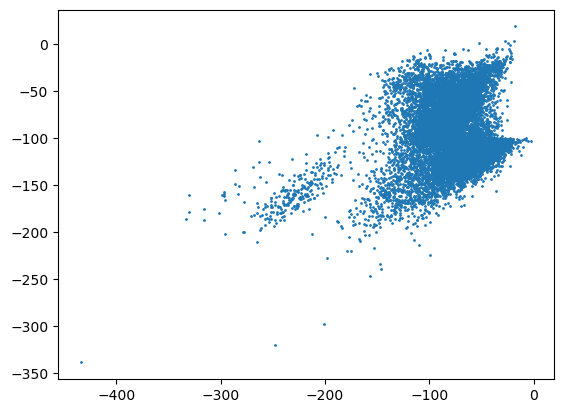

In [15]:
import matplotlib.pyplot as plt

tetrode_ind = 1
plt.scatter(
    spike_waveform_features[tetrode_ind][:, 0],
    spike_waveform_features[tetrode_ind][:, 1],
    s=1,
)